C:\Users\14089\AppData\Local\Temp\ipykernel_7420\286162811.py:280: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Serial Number     997213 non-null  int64         
 1   List Year         997213 non-null  int64         
 2   Date Recorded     997211 non-null  datetime64[ns]
 3   Town              997213 non-null  object        
 4   Address           997162 non-null  object        
 5   Assessed Value    997213 non-null  int64         
 6   Sale Amount       997213 non-null  float64       
 7   Sales Ratio       997213 non-null  float64       
 8   Property Type     614767 non-null  object        
 9   Residential Type  608904 non-null  object        
 10  Non Use Code      289681 non-null  object        
 11  Assessor Remarks  149864 non-null  object        
 12  OPM remarks       9934 non-null    object        
 13  Location          197697 non-null  object        
 14  Reco

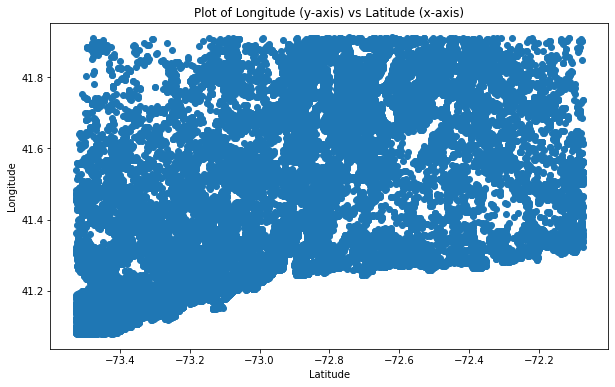

0          3-6
5          8-8
33         8-7
56        5-13
66         3-8
          ... 
997174     6-9
997181     3-5
997182    5-16
997193     2-3
997206     2-7
Name: LocationGroup, Length: 80663, dtype: object


c:\users\14089\appdata\local\programs\python\python38\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


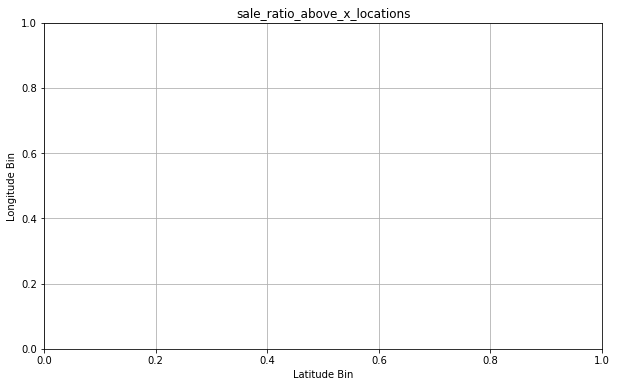

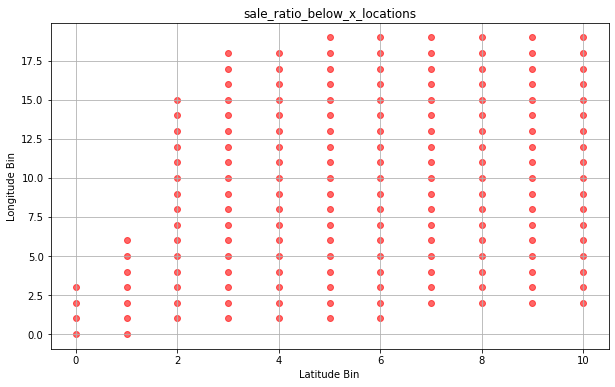

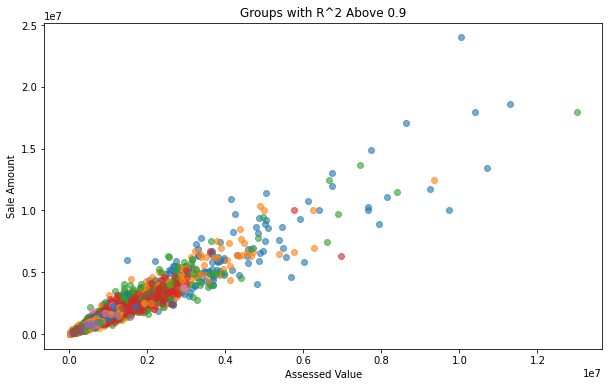

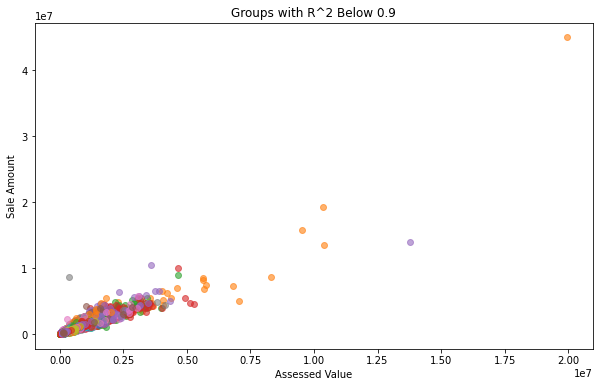

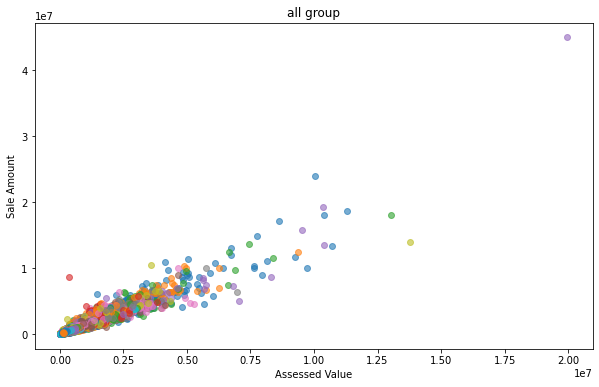

['Single Family' 'Condo' 'Three Family' 'Two Family']
Residential Type
Single Family    60299
Condo            15718
Two Family        3159
Three Family      1487
Name: count, dtype: int64
Index(['Town', 'Assessed Value', 'Sale Amount', 'Recorded Year',
       'Recorded Month', 'LatBin', 'LonBin', 'Residential Type_Condo',
       'Residential Type_Single Family', 'Residential Type_Three Family',
       'Residential Type_Two Family'],
      dtype='object')


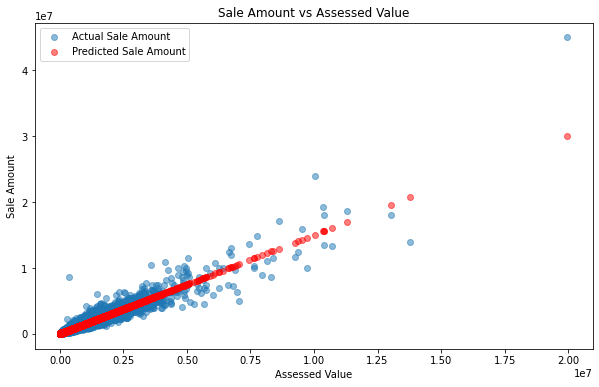

0         231224.345472
5         821697.585995
33        462083.640716
56        156231.835552
66        157737.564440
              ...      
997174    188897.643343
997181    427694.321090
997182    195217.018382
997193    804442.406642
997206    213686.086647
Name: Predicted Sale Amount, Length: 80663, dtype: float64


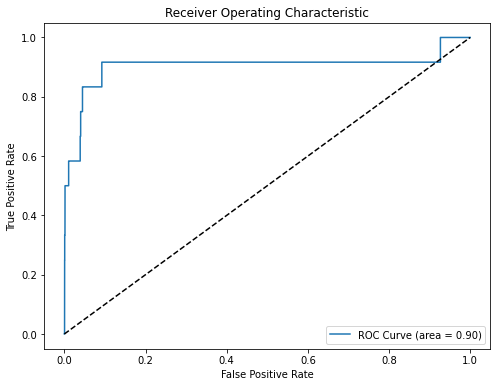

ROC AUC score: 0.9034213256293577
                            OLS Regression Results                            
Dep. Variable:       Q("Sale Amount")   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 1.935e+05
Date:                Sun, 10 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:34:54   Log-Likelihood:            -1.0837e+06
No. Observations:               80663   AIC:                         2.167e+06
Df Residuals:                   80657   BIC:                         2.167e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [35]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc



def analyze_sale_amount_correlation(df, threshold, sample_size=10000):
    """
    Analyzes the correlation of 'Assessed Value', 'Residential Type'
    with 'Sale Amount' using linear regression.

    :param df: pandas DataFrame containing the data
    """
    # Taking a sample if the dataframe is large
    #if len(df) > sample_size:
    #    sample_df = df.sample(n=sample_size, random_state=1).copy()
    #else:
    sample_df = df.copy()
    
    print(df['Residential Type'].unique())
    print(sample_df['Residential Type'].value_counts())
    
    if 'Residential Type' in sample_df.columns:
        sample_df = pd.get_dummies(sample_df, columns=['Residential Type'], drop_first=False)

    # Remove specific columns from the sample DataFrame
    columns_to_remove = ['Serial Number', 'List Year', 'Date Recorded', 'Address', 
                         'Property Type', 'Non Use Code', 'Assessor Remarks', 'OPM remarks', 
#                      'Location', 'Recorded Year', 'Recorded Month','LatBin', 'LonBin', 
                         'Location',  
#                         'LocationGroup', 'Sales Ratio', 'Longitude','Latitude', 'LocationGroupCode', 'Town']
                         'LocationGroup', 'Sales Ratio', 'Longitude','Latitude', 'LocationGroupCode']
    sample_df = sample_df.drop(columns_to_remove, axis=1, errors='ignore')
    print(sample_df.columns)
    

    # Define the model
    formula = 'Q("Sale Amount") ~ Q("Assessed Value") + Q("Recorded Year")'
    for col in sample_df.columns:
        if col.startswith('Residential Type_'):
            formula += f' + Q("{col}")'

    model = ols(formula, data=sample_df).fit()
    plot_sale_amount_vs_assessed_value(sample_df, model)
    
    df['Predicted Sale Amount'] = model.predict(sample_df)
    print(df['Predicted Sale Amount'])
    
    
    # Calculate the predicted sales ratio
    df['Predicted Sales Ratio'] = df['Predicted Sale Amount'] / df['Assessed Value']

    # Define a threshold for classifying sales ratios
    # Here, we'll use 1 as the threshold for simplicity

    # Categorize the actual and predicted sales ratios as 0 or 1
    df['Actual Ratio Category'] = (df['Sales Ratio'] >= threshold).astype(int)
    df['Predicted Ratio Category'] = (df['Predicted Sales Ratio'] >= threshold).astype(int)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(df['Actual Ratio Category'], df['Predicted Sales Ratio'])

    # Get ROC curve
    fpr, tpr, thresholds = roc_curve(df['Actual Ratio Category'], df['Predicted Sales Ratio'])

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print(f'ROC AUC score: {roc_auc}')

    # Return the model
    return model.summary() 

def plot_sale_amount_vs_assessed_value(df, model):
    """
    Plot actual and predicted 'Sale Amount' against 'Assessed Value'.

    :param df: pandas DataFrame containing the data
    :param model: A fitted regression model
    """
    # Prediction based on model
    df['Predicted Sale Amount'] = model.predict(df)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Assessed Value'], df['Sale Amount'], alpha=0.5, label='Actual Sale Amount')
    plt.scatter(df['Assessed Value'], df['Predicted Sale Amount'], alpha=0.5, color='red', label='Predicted Sale Amount')
    plt.title('Sale Amount vs Assessed Value')
    plt.xlabel('Assessed Value')
    plt.ylabel('Sale Amount')
    plt.legend()
    plt.show()

def plot_locations(locations, title, color):
    plt.figure(figsize=(10, 6))
    for lat_bin, lon_bin in locations:
        plt.scatter(lat_bin, lon_bin, alpha=0.6, color=color)
    plt.title(title)
    plt.xlabel('Latitude Bin')
    plt.ylabel('Longitude Bin')
    plt.grid(True)
    plt.show()

def plot_data(groups, title):
    plt.figure(figsize=(10, 6))
    for group in groups:
        plt.scatter(group['Assessed Value'], group['Sale Amount'], alpha=0.6)
    plt.title(title)
    plt.xlabel('Assessed Value')
    plt.ylabel('Sale Amount')
    plt.show()

    
def plot_sales_ratio(df, x_column):
    """
    Plots Sales Ratio against a specified column (Recorded Year or Recorded Month).

    :param df: pandas DataFrame containing the data
    :param x_column: Column name to plot on the x-axis ('Recorded Year' or 'Recorded Month')
    """
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_column], df['Sales Ratio'], alpha=0.6)
    plt.title(f'{x_column} vs Sales Ratio')
    plt.xlabel(x_column)
    plt.ylabel('Sales Ratio')
    plt.grid(True)
    plt.show()

def train_evaluate_logistic_regression(X, y, test_size=0.2, random_state=42):
    """
    Trains a logistic regression model and evaluates it on a test set.

    :param X: DataFrame or array-like, features for the model
    :param y: Series or array-like, target variable for the model
    :param test_size: float, proportion of the dataset to include in the test split
    :param random_state: int, seed for random number generator for reproducibility
    :return: tuple, containing the trained model, classification report and accuracy
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the Logistic Regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Evaluate the model on the test data
    predictions = model.predict(X_test)
    report = classification_report(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)

    return model, report, accuracy

def eliminate_outlier_loc(df):

    # Extracting longitude and latitude
    df['Longitude'], df['Latitude'] = zip(*df['Location'].apply(lambda x: 
                                                            (float(x.split(' ')[1][1:]), 
                                                             float(x.split(' ')[2][:-1]))))
    # Filter out outliers: keep only 5th to 95th percentile
    lat_5th = df['Latitude'].quantile(0.05)
    lat_95th = df['Latitude'].quantile(0.95)
    lon_5th = df['Longitude'].quantile(0.05)
    lon_95th = df['Longitude'].quantile(0.95)
    
    df = df[(df['Latitude'] >= lat_5th) & (df['Latitude'] <= lat_95th) & 
        (df['Longitude'] >= lon_5th) & (df['Longitude'] <= lon_95th)]

    plt.figure(figsize=(10, 6))
    plt.scatter(df['Longitude'], df['Latitude'])  # Swapping the usual order
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Plot of Longitude (y-axis) vs Latitude (x-axis)')
    plt.show()
    
def check_loc_dependency(df, sales_ratio_above):
    
    # Grouping locations into squares
    bin_size_lat = 0.1
    bin_size_lon = 0.1

    # Create bin edges for latitude and longitude
    lat_bins = np.arange(df['Latitude'].min(), df['Latitude'].max() + bin_size_lat, bin_size_lat)
    lon_bins = np.arange(df['Longitude'].min(), df['Longitude'].max() + bin_size_lon, bin_size_lon)
    #print(lat_bins)
    #print(lon_bins)

    # Create binned categories for latitude and longitude
    df['LatBin'] = pd.cut(df['Latitude'], bins=lat_bins, labels=range(len(lat_bins) - 1))
    df['LonBin'] = pd.cut(df['Longitude'], bins=lon_bins, labels=range(len(lon_bins) - 1))

    # Create a new column for grouped location
    df['LocationGroup'] = df['LatBin'].astype(str) + '-' + df['LonBin'].astype(str)
    print(df['LocationGroup'] )

    # Take a random sample of 1000 rows
    #sample_df = df.sample(n=1000, random_state=1)
    #print(sample_df['LocationGroup'] )

    # Convert LocationGroup to a numeric code
    df['LocationGroupCode'] = df['LocationGroup'].astype('category').cat.codes

    # Variables to plot
    variables = ['Recorded Year', 'Recorded Month', 'Assessed Value', 'Sale Amount']

    # Group by LocationGroupCode
    grouped = df.groupby(['LatBin', 'LonBin'])

    # Initialize lists to store locations
    r_squared_above_09 = []
    r_squared_below_09 = []
    r_squared_above_09_locations = []
    r_squared_below_09_locations = []
    sampledAllData = []
    sale_ratio_above_x_locations = []
    sale_ratio_below_x_locations = []

    for (lat_bin, lon_bin), group in grouped:
        X = group['Assessed Value']
        y = group['Sale Amount']
        X = sm.add_constant(X)  # adding a constant

        model = sm.OLS(y, X).fit()
        r_squared = model.rsquared

        # Check if model has more than just an intercept
        if len(model.params) > 1:
            coef = model.params[1]  # Coefficient for 'Assessed Value'
            sampledAllData.append(group)
        
            if group['Sales Ratio'].mean() >= sales_ratio_above:
                sale_ratio_above_x_locations.append((lat_bin, lon_bin))
            else:
                sale_ratio_below_x_locations.append((lat_bin, lon_bin)) 
        
            # Check conditions
            if r_squared > 0.9:
                r_squared_above_09.append(group)
                r_squared_above_09_locations.append((lat_bin, lon_bin))
            else:
                r_squared_below_09.append(group)
                r_squared_below_09_locations.append((lat_bin, lon_bin))

    # Plotting
    #plot_locations(r_squared_above_09_locations, 'Locations with R^2 Above 0.9', 'blue')
    #plot_locations(r_squared_below_09_locations, 'Locations with R^2 Below 0.9', 'red')
    plot_locations(sale_ratio_above_x_locations, 'sale_ratio_above_x_locations', 'blue')
    plot_locations(sale_ratio_below_x_locations, 'sale_ratio_below_x_locations', 'red')

    # Determine common axis limits
    #all_data = pd.concat(list(data_coef_near_zero.values()) + list(data_coef_near_one.values()))
    #x_lim = (all_data['Assessed Value'].min(), all_data['Assessed Value'].max())
    #y_lim = (all_data['Sale Amount'].min(), all_data['Sale Amount'].max())

    # Plotting
    plot_data(r_squared_above_09, 'Groups with R^2 Above 0.9')
    plot_data(r_squared_below_09, 'Groups with R^2 Below 0.9')
    plot_data(sampledAllData, 'all group')


    
# Load the CSV file into a Pandas DataFrame
file_path = 'Real_Estate_Sales_2001-2020_GL.csv'  # Update this with file path
df = pd.read_csv(file_path)

# Display initial shape of the DataFrame for reference
df['Date Recorded'] = pd.to_datetime(df['Date Recorded'])
df['Recorded Year'] = df['Date Recorded'].dt.year
df['Recorded Month'] = df['Date Recorded'].dt.month
df.info()

#print(df.columns)
# Drop rows where 'Location','Property Type', 'Residential Type' is null
df = df.dropna(subset=['Location'])
df = df.dropna(subset=['Property Type', 'Residential Type'])

# Keep rows where 'Residential Type' is not below condition
#df = df[df['Residential Type'] != 'Two Family']
df = df[df['Residential Type'] != 'Four Family']

# Keep rows where 'Non Use Code', 'Assessor Remarks', and 'OPM remarks' are null
df = df[df['Non Use Code'].isna() & df['Assessor Remarks'].isna() & df['OPM remarks'].isna()]

for c in df.columns[2:]:
    print(c, df[c].unique())

df.info()

# Eliminate outlier location for data cleaning
eliminate_outlier_loc(df)

# Check location dependency
sales_ratio_above = 2.5
check_loc_dependency(df, sales_ratio_above)


# Train the Linear Regression model and calculate predicted 'Sale Amount'
print(analyze_sale_amount_correlation(df, sales_ratio_above))

predicted_sale_amount_2d = df['Predicted Sale Amount'].values.reshape(-1, 1)
# Create a label for whether 'Sales Ratio' is above certain value
df['Sales Ratio Above x'] = (df['Sales Ratio'] >= sales_ratio_above).astype(int)

X = predicted_sale_amount_2d
y = df['Sales Ratio Above x']  # Target variable

# Train and evaluate the logistic regression model
logistic_model, report, accuracy = train_evaluate_logistic_regression(X,y)
print(report)
print("Accuracy:", accuracy)


